In [1]:
from os import makedirs
makedirs("data", exist_ok=True)
from urllib.request import urlretrieve
urlretrieve('https://git.io/vXTVC', 'data/txtdata.csv')

('data/txtdata.csv', <http.client.HTTPMessage at 0x1db2cfdbac8>)

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

In [3]:
%matplotlib inline

In [4]:
figsize(12.5, 3.5)

(0, 74)

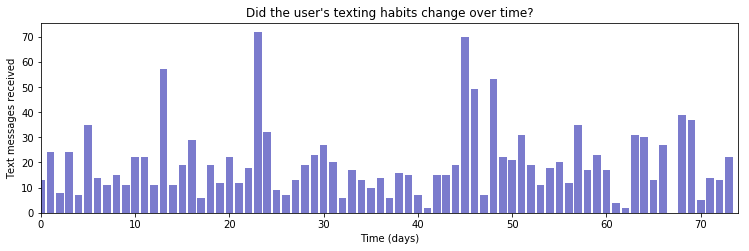

In [5]:
count_data = np.loadtxt('data/txtdata.csv')
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, alpha=0.6, color="#2323ad")
plt.xlabel("Time (days)")
plt.ylabel("Text messages received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data)

## $C_i \sim Poi(\lambda)$


In [6]:
import pymc as pm

alpha = 1.0 / count_data.mean()

lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)
tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

In [7]:
print(lambda_1.random(), lambda_2.random(), tau.random())

8.144387901917808 2.280172626156717 8


In [8]:
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)
    out[:tau]=lambda_1
    out[tau:]=lambda_2
    return out

In [9]:
observation = pm.Poisson("obs", lambda_, value=count_data,observed=True)
model = pm.Model([observation, lambda_1, lambda_2,tau])

In [10]:
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000)

 [-----------------100%-----------------] 40000 of 40000 complete in 4.9 sec

In [11]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

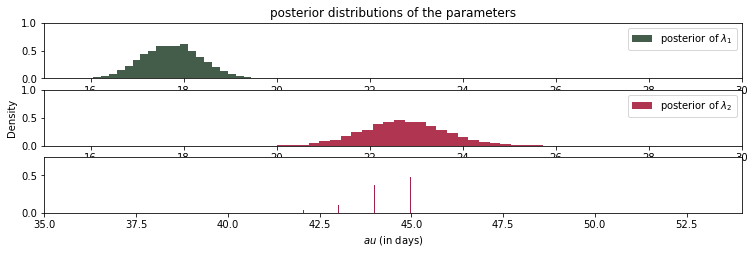

In [12]:
ax = plt.subplot(3,1,1)
ax.set_autoscaley_on(False)
plt.hist(lambda_1_samples, histtype="stepfilled", bins=30, alpha=0.85, color="#23412A", normed=True, label="posterior of $\lambda_1$")
plt.legend(loc="upper right")
plt.title("posterior distributions of the parameters")
plt.xlim([15,30])
ax = plt.subplot(3,1,2)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype="stepfilled", bins=30, alpha=0.85, color="#A21232",normed=True, label="posterior of $\lambda_2$")
plt.legend(loc="upper right")
plt.xlim([15,30])
plt.ylabel('Density')
ax = plt.subplot(3,1,3)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins = n_count_data, alpha=1, label="porterior of $\tau$", color="#a1234a", weights=w, rwidth=0.2)
plt.ylim([0, 0.75])
plt.xlim([35, len(count_data)-20])
plt.xlabel('$\tau$ (in days)')